In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls "/content/drive/MyDrive/Dataset/plantvillage_dataset"


best_model_finetuned.keras  color  grayscale  saved_models  segmented  Sondos


In [5]:
allowed_classes = [
    "Tomato___Target_Spot",
    "Pepper,_bell___Bacterial_spot",
    "Grape___Black_rot",
    "Corn_(maize)___Common_rust_",
    "Cherry_(including_sour)___Powdery_mildew"
] # 5 CLASSES


In [6]:
import os
dataset_path ="/content/drive/MyDrive/Dataset/plantvillage_dataset/color"

selected_classes = [
    cls for cls in allowed_classes
    if os.path.isdir(os.path.join(dataset_path, cls))
]

print("Selected Classes:")
for cls in selected_classes:
    print(cls)

print("Number of classes:", len(selected_classes))


Selected Classes:
Tomato___Target_Spot
Pepper,_bell___Bacterial_spot
Grape___Black_rot
Corn_(maize)___Common_rust_
Cherry_(including_sour)___Powdery_mildew
Number of classes: 5


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

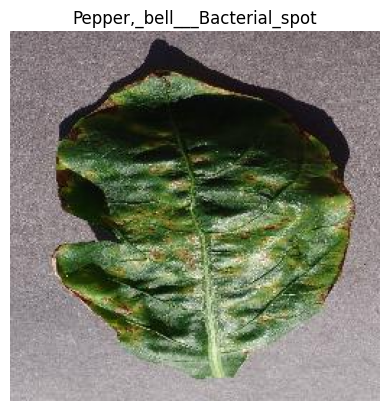

In [7]:
import random
import os
import cv2
import matplotlib.pyplot as plt


class_name = random.choice(selected_classes)
class_path = os.path.join(dataset_path, class_name)

img_name = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, img_name)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title(class_name)
plt.axis("off")


In [8]:
import tensorflow as tf

InceptionV3 = tf.keras.applications.InceptionV3
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

IMG_SIZE = 299
BATCH_SIZE = 16
SEED = 42

def preprocess_inception(x, y):
    x = tf.cast(x, tf.float32)
    x = preprocess_input(x)
    return x, y

full_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    class_names=selected_classes,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="categorical",  # one-hot encoded
    shuffle=True,
    seed=SEED
)

full_ds = full_ds.map(preprocess_inception, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)


Found 5825 files belonging to 5 classes.


In [9]:
#CHECK FOR NORMALIZATION AND RESIZING
for images, labels in full_ds.take(1):
    print("Min:", tf.reduce_min(images).numpy())
    print("Max:", tf.reduce_max(images).numpy())
    print("Shape:", images.shape)

Min: -1.0
Max: 1.0
Shape: (16, 299, 299, 3)


In [10]:
#(70% train, 15% val, 15% test)
dataset_size = tf.data.experimental.cardinality(full_ds).numpy()

train_size = int(0.7 * dataset_size)
val_size   = int(0.15 * dataset_size)

train_ds = full_ds.take(train_size)
remaining_ds = full_ds.skip(train_size)

val_ds  = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)


In [11]:
print("Total batches in full_ds :", tf.data.experimental.cardinality(full_ds).numpy())
print("Train batches           :", tf.data.experimental.cardinality(train_ds).numpy())
print("Validation batches      :", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches            :", tf.data.experimental.cardinality(test_ds).numpy())

Total batches in full_ds : 365
Train batches           : 255
Validation batches      : 54
Test batches            : 56


In [12]:
def count_images(ds):
    return sum(1 for _ in ds.unbatch())

print("Total images :", count_images(full_ds))
print("Train images :", count_images(train_ds))
print("Val images   :", count_images(val_ds))
print("Test images  :", count_images(test_ds))


Total images : 5825
Train images : 4080
Val images   : 864
Test images  : 881


In [13]:
#DYNAMIC AUGMENTATION (TRAIN ONLY)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

def augment(x, y):
    x = data_augmentation(x, training=True)
    return x, y

train_ds = train_ds.map(
    augment,
    num_parallel_calls=tf.data.AUTOTUNE
)

In [14]:
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.prefetch(tf.data.AUTOTUNE)


In [15]:
def get_class_counts(ds, name):
    labels = []
    for _, y in ds.unbatch():
        labels.append(int(tf.argmax(y)))
    from collections import Counter
    print(f"{name} class counts:", dict(Counter(labels)))

get_class_counts(train_ds, "TRAIN")
get_class_counts(val_ds, "VAL")
get_class_counts(test_ds, "TEST")


TRAIN class counts: {2: 809, 3: 843, 4: 727, 1: 708, 0: 993}
VAL class counts: {4: 143, 0: 211, 3: 186, 2: 177, 1: 147}
TEST class counts: {1: 148, 3: 173, 4: 175, 0: 188, 2: 197}


In [16]:
#CLASS WEIGHTS
import numpy as np

labels = []

for _, y in train_ds.unbatch():
    labels.append(np.argmax(y.numpy()))

labels = np.array(labels)


In [17]:
from collections import Counter

class_counts = Counter(labels)
clean_class_counts = {int(k): int(v) for k, v in class_counts.items()}
print("Class counts:", clean_class_counts)


Class counts: {4: 731, 3: 836, 0: 989, 2: 812, 1: 712}


In [18]:
class_index_to_name = {i: name for i, name in enumerate(selected_classes)}
print("Class distribution in TRAIN:")
for class_idx, count in clean_class_counts.items():
    class_name = class_index_to_name[class_idx]
    print(f"{class_idx} ({class_name}) → {count} samples")


Class distribution in TRAIN:
4 (Cherry_(including_sour)___Powdery_mildew) → 731 samples
3 (Corn_(maize)___Common_rust_) → 836 samples
0 (Tomato___Target_Spot) → 989 samples
2 (Grape___Black_rot) → 812 samples
1 (Pepper,_bell___Bacterial_spot) → 712 samples


In [19]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

num_classes = len(class_counts)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=labels
)

class_weight_dict = {int(i): float(w) for i, w in enumerate(class_weights)}
print("Class weights:", class_weight_dict)

Class weights: {0: 0.8250758341759353, 1: 1.146067415730337, 2: 1.0049261083743843, 3: 0.9760765550239234, 4: 1.1162790697674418}


In [20]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/Plantvillage_Dataset/best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [21]:
earlystop_cb =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [22]:
base_model = tf.keras.applications.InceptionV3(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Transfer learning (start frozen)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(len(selected_classes), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,328,613 (85.18 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [25]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/Plantvillage_Dataset/best_model.keras")


In [ ]:
EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb],
    class_weight=class_weight_dict
)


Accuracy: 0.9807037457434733
Precision (macro): 0.9803097208075965
Recall (macro): 0.9809277871886566
F1-score (macro): 0.9805688439916942

Classification Report:
                                          precision    recall  f1-score   support

                    Tomato___Target_Spot       0.96      0.96      0.96       200
           Pepper,_bell___Bacterial_spot       0.96      0.98      0.97       138
                       Grape___Black_rot       0.99      0.99      0.99       198
             Corn_(maize)___Common_rust_       1.00      1.00      1.00       170
Cherry_(including_sour)___Powdery_mildew       0.99      0.97      0.98       175

                                accuracy                           0.98       881
                               macro avg       0.98      0.98      0.98       881
                            weighted avg       0.98      0.98      0.98       881



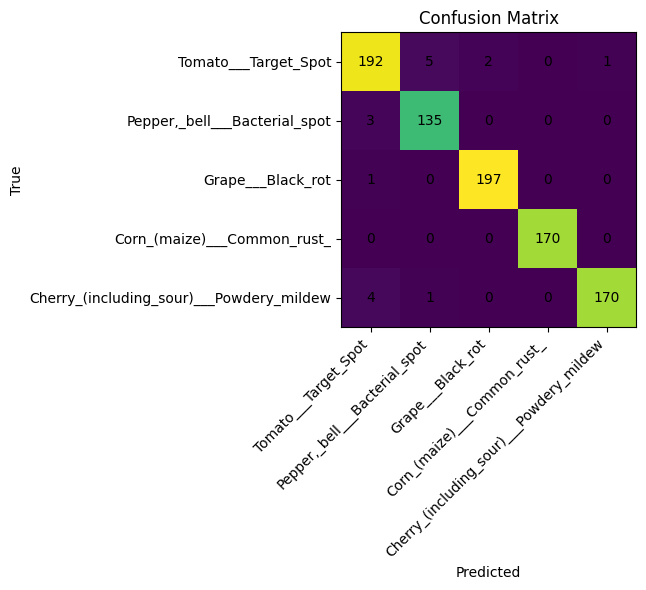

In [29]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

eval_ds = test_ds  # or val_ds

y_true_list = []
y_pred_list = []

for x_batch, y_batch in eval_ds:
    # Predict
    probs = model.predict(x_batch, verbose=0)
    preds = np.argmax(probs, axis=1)

    # True labels (handle one-hot or sparse)
    yb = y_batch.numpy()
    if yb.ndim > 1:
        yb = np.argmax(yb, axis=1)

    y_true_list.append(yb)
    y_pred_list.append(preds)

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision (macro):", precision_score(y_true, y_pred, average="macro", zero_division=0))
print("Recall (macro):", recall_score(y_true, y_pred, average="macro", zero_division=0))
print("F1-score (macro):", f1_score(y_true, y_pred, average="macro", zero_division=0))

# Use the dataset's own class order if available
class_names = getattr(eval_ds, "class_names", selected_classes)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.show()
